In [1]:
%matplotlib inline

In [2]:
# These are values defined in the Arduino code and documented in 
# "Bluetooth.java" in the application

In [3]:
D_SAMPLING_FREQUENCY = 250.0

In [4]:
### Pull in the libraries and define the functions we will be using

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

In [6]:
# This function pulls in the data for each channel

In [7]:
def getChannelData(iChannel, strTestCase):
    cwd = os.getcwd()
    cwd = cwd+'\\TrainingData\\'+strTestCase

    f = []
    for (dirpath, dirnames, filenames) in os.walk(cwd):
        f.extend(filenames)
        break
        
    strFileSearch = 'Trace0' + str(iChannel)
    strFiles = filter(lambda x:strFileSearch in x, f)
    
    
    for idx in range(0, len(strFiles)):
        fh = open(cwd+'\\'+strFiles[idx], 'rb')
        # read the data into numpy
        if(idx==0):
            x = np.fromfile(fh, dtype=('>f'))
        else:
            x = np.append(x, np.fromfile(fh, dtype=('>f')))
        fh.close()
    
    return (x,strFiles)

In [8]:
# This function pulls the arrays from the data file function into a
# single data frame
def getDataAsFrame(strTestCase):

    (x1,strFiles1) = getChannelData(1,strFolder)
    (x2,strFiles2) = getChannelData(2,strFolder)
    (x3,strFiles3) = getChannelData(3,strFolder)
    (x4,strFiles4) = getChannelData(4,strFolder)

    dfData = pd.DataFrame(data={(strTestCase+'_Ch1'):x1, 
                                (strTestCase+'_Ch2'):x2, 
                                (strTestCase+'_Ch3'):x3, 
                                (strTestCase+'_Ch4'):x4})
    
    dfDataRollingMean = dfData.rolling(window=15,center=True).mean()
    dfDataRollingMean.columns = [(strTestCase+'_Ch1_rm'),
                                (strTestCase+'_Ch2_rm'),
                                (strTestCase+'_Ch3_rm'),
                                (strTestCase+'_Ch4_rm')]
    
    for column in dfDataRollingMean:
        dfDataRollingMean[column].fillna(dfDataRollingMean[column].mean(), inplace=True)
    
    
    dfData = pd.concat([dfData, dfDataRollingMean],
                       axis=1, join_axes = [dfData.index])
    
    return dfData

In [9]:
# This function appends one dataframe to another

In [10]:
def appendDataAsFrame(strTestCase, dfData):
    dfNew = getDataAsFrame(strTestCase)
    dfDataOut = pd.concat([dfData, dfNew], axis=1, join_axes=[dfData.index])

    return dfDataOut

In [11]:
# This function plots the timebase data in the data frame

In [12]:
def plotFolder(strFolder):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=.5, hspace=0.5)

    strColName = strFolder+'_Ch1'
    ax = dfData.plot(x='t', y=[strColName, strColName+'_rm'], 
                     ax=axes[0,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = strFolder+'_Ch2'
    ax = dfData.plot(x='t', y=[strColName, strColName+'_rm'], 
                     ax=axes[0,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = strFolder+'_Ch3'
    ax = dfData.plot(x='t', y=[strColName, strColName+'_rm'], 
                     ax=axes[1,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = strFolder+'_Ch4'
    ax = dfData.plot(x='t', y=[strColName, strColName+'_rm'], 
                     ax=axes[1,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

In [13]:
# This function plots the histograms of two different classes of data

In [14]:
def plotClasses(strClass1, strClass2):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    strSeries1 = strClass1+'_Ch1'
    strSeries2 = strClass2+'_Ch1'
    ax1 = dfData[strSeries1].hist(figsize=(12,12), ax=axes[0,0], alpha = 0.4, label=strSeries1)
    ax2 = dfData[strSeries2].hist(figsize=(12,12), ax=axes[0,0], alpha = 0.4, label=strSeries2)
    ax1.legend()
    
    strSeries1 = strClass1+'_Ch2'
    strSeries2 = strClass2+'_Ch2'
    ax1 = dfData[strSeries1].hist(figsize=(12,12), ax=axes[0,1], alpha = 0.4, label=strSeries1)
    ax2 = dfData[strSeries2].hist(figsize=(12,12), ax=axes[0,1], alpha = 0.4, label=strSeries2)
    ax1.legend()
    
    strSeries1 = strClass1+'_Ch3'
    strSeries2 = strClass2+'_Ch3'
    ax1 = dfData[strSeries1].hist(figsize=(12,12), ax=axes[1,0], alpha = 0.4, label=strSeries1)
    ax2 = dfData[strSeries2].hist(figsize=(12,12), ax=axes[1,0], alpha = 0.4, label=strSeries2)
    ax1.legend()
    
    strSeries1 = strClass1+'_Ch4'
    strSeries2 = strClass2+'_Ch4'
    ax1 = dfData[strSeries1].hist(figsize=(12,12), ax=axes[1,1], alpha = 0.4, label=strSeries1)
    ax2 = dfData[strSeries2].hist(figsize=(12,12), ax=axes[1,1], alpha = 0.4, label=strSeries2)
    ax1.legend()
    
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    strSeries1 = strClass1+'_Ch1_rm'
    strSeries2 = strClass2+'_Ch1_rm'
    ax1 = dfData[strSeries1].hist(figsize=(12,12), ax=axes[0,0], alpha = 0.4, label=strSeries1)
    ax2 = dfData[strSeries2].hist(figsize=(12,12), ax=axes[0,0], alpha = 0.4, label=strSeries2)
    ax1.legend()
    
    strSeries1 = strClass1+'_Ch2_rm'
    strSeries2 = strClass2+'_Ch2_rm'
    ax1 = dfData[strSeries1].hist(figsize=(12,12), ax=axes[0,1], alpha = 0.4, label=strSeries1)
    ax2 = dfData[strSeries2].hist(figsize=(12,12), ax=axes[0,1], alpha = 0.4, label=strSeries2)
    ax1.legend()
    
    strSeries1 = strClass1+'_Ch3_rm'
    strSeries2 = strClass2+'_Ch3_rm'
    ax1 = dfData[strSeries1].hist(figsize=(12,12), ax=axes[1,0], alpha = 0.4, label=strSeries1)
    ax2 = dfData[strSeries2].hist(figsize=(12,12), ax=axes[1,0], alpha = 0.4, label=strSeries2)
    ax1.legend()
    
    strSeries1 = strClass1+'_Ch4_rm'
    strSeries2 = strClass2+'_Ch4_rm'
    ax1 = dfData[strSeries1].hist(figsize=(12,12), ax=axes[1,1], alpha = 0.4, label=strSeries1)
    ax2 = dfData[strSeries2].hist(figsize=(12,12), ax=axes[1,1], alpha = 0.4, label=strSeries2)
    ax1.legend()

In [15]:
# plot correlation by channel

In [16]:
def plotCorrChannel(strChannel):
    
    # Section the data and calc correlation matrix
    plot_cols = [col for col in dfData.columns if strChannel in col]
    dfPlot = dfData[plot_cols]
    correlations = dfPlot.corr()
    names = list(dfPlot)
    iCols = len(dfPlot.columns)
    
    # plot correlation matrix
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,iCols,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

In [17]:
# Begin by getting the data into python and plotting it out.

In [18]:
strFolder = 'Cobble1'
dfData = getDataAsFrame(strFolder)
strFolder = 'Cobble2'
dfData = appendDataAsFrame(strFolder, dfData)
strFolder = 'Carpet1'
dfData = appendDataAsFrame(strFolder, dfData)
strFolder = 'Carpet2'
dfData = appendDataAsFrame(strFolder, dfData)
strFolder = 'Tile1'
dfData = appendDataAsFrame(strFolder, dfData)
strFolder = 'Tile2'
dfData = appendDataAsFrame(strFolder, dfData)

dfData['t'] = pd.Series(np.divide(range(0,len(dfData.index)),D_SAMPLING_FREQUENCY), 
                        index=dfData.index)

In [19]:
# Plot out the data

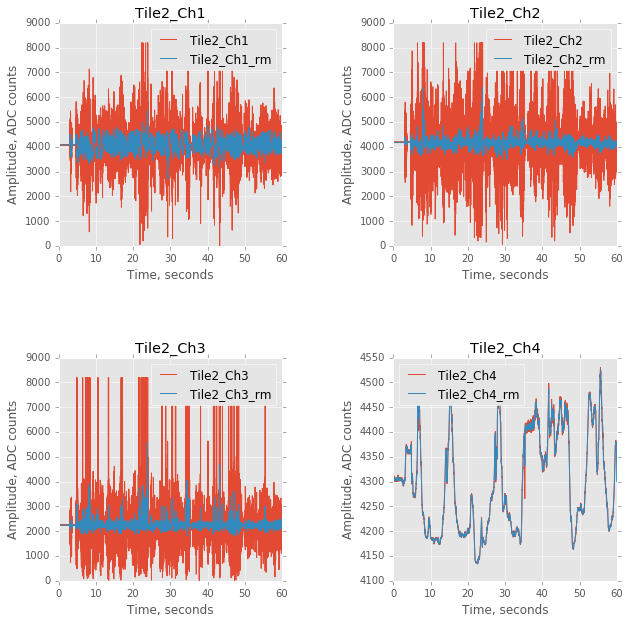

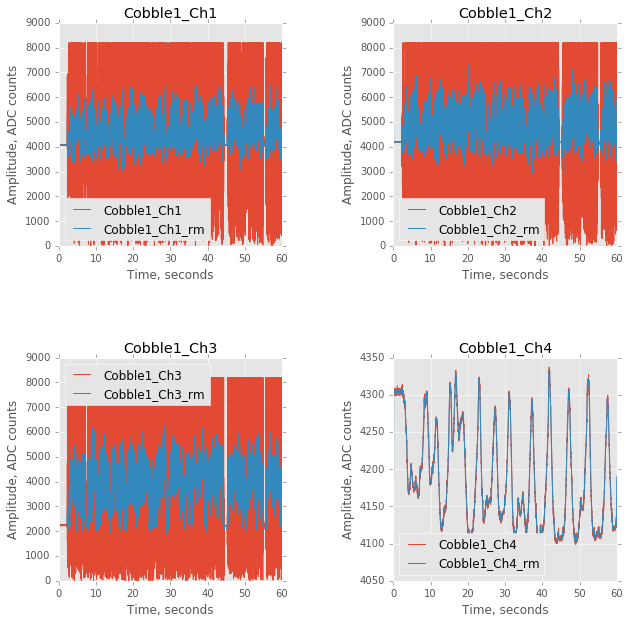

In [20]:
plotFolder(strFolder)
plotFolder('Cobble1')

In [21]:
dfData.head(10)

,Cobble1_Ch1,Cobble1_Ch2,Cobble1_Ch3,Cobble1_Ch4,Cobble1_Ch1_rm,Cobble1_Ch2_rm,Cobble1_Ch3_rm,Cobble1_Ch4_rm,Cobble2_Ch1,Cobble2_Ch2,...,Tile1_Ch4_rm,Tile2_Ch1,Tile2_Ch2,Tile2_Ch3,Tile2_Ch4,Tile2_Ch1_rm,Tile2_Ch2_rm,Tile2_Ch3_rm,Tile2_Ch4_rm,t
0,4080.0,4178.0,2237.0,4301.0,4619.763802,4841.966836,3820.884274,4189.551337,4076.0,4158.0,...,4506.400187,4078.0,4175.0,2244.0,4306.0,4076.344566,4170.572481,2297.693981,4300.378900,0.000
1,4081.0,4181.0,2227.0,4301.0,4619.763802,4841.966836,3820.884274,4189.551337,4080.0,4159.0,...,4506.400187,4081.0,4181.0,2247.0,4307.0,4076.344566,4170.572481,2297.693981,4300.378900,0.004
2,4084.0,4188.0,2239.0,4301.0,4619.763802,4841.966836,3820.884274,4189.551337,4077.0,4158.0,...,4506.400187,4086.0,4180.0,2246.0,4307.0,4076.344566,4170.572481,2297.693981,4300.378900,0.008
3,4077.0,4181.0,2242.0,4302.0,4619.763802,4841.966836,3820.884274,4189.551337,4077.0,4164.0,...,4506.400187,4080.0,4179.0,2240.0,4308.0,4076.344566,4170.572481,2297.693981,4300.378900,0.012
4,4076.0,4188.0,2240.0,4302.0,4619.763802,4841.966836,3820.884274,4189.551337,4082.0,4160.0,...,4506.400187,4080.0,4180.0,2235.0,4309.0,4076.344566,4170.572481,2297.693981,4300.378900,0.016
5,4083.0,4182.0,2237.0,4304.0,4619.763802,4841.966836,3820.884274,4189.551337,4077.0,4164.0,...,4506.400187,4079.0,4175.0,2242.0,4310.0,4076.344566,4170.572481,2297.693981,4300.378900,0.020
6,4075.0,4185.0,2233.0,4303.0,4619.763802,4841.966836,3820.884274,4189.551337,4084.0,4158.0,...,4506.400187,4082.0,4178.0,2243.0,4311.0,4076.344566,4170.572481,2297.693981,4300.378900,0.024
7,4078.0,4179.0,2232.0,4305.0,4079.600000,4183.400000,2235.800000,4304.400000,4087.0,4164.0,...,4690.466667,4077.0,4176.0,2234.0,4309.0,4079.200000,4177.666667,2242.000000,4307.600000,0.028
8,4084.0,4178.0,2235.0,4306.0,4080.000000,4183.533333,2235.466667,4304.533333,4074.0,4160.0,...,4692.133333,4081.0,4177.0,2240.0,4308.0,4079.266667,4177.733333,2242.066667,4307.466667,0.032
9,4091.0,4184.0,2236.0,4308.0,4079.666667,4183.466667,2236.000000,4304.666667,4082.0,4161.0,...,4693.800000,4079.0,4179.0,2249.0,4308.0,4078.933333,4177.266667,2241.733333,4307.200000,0.036


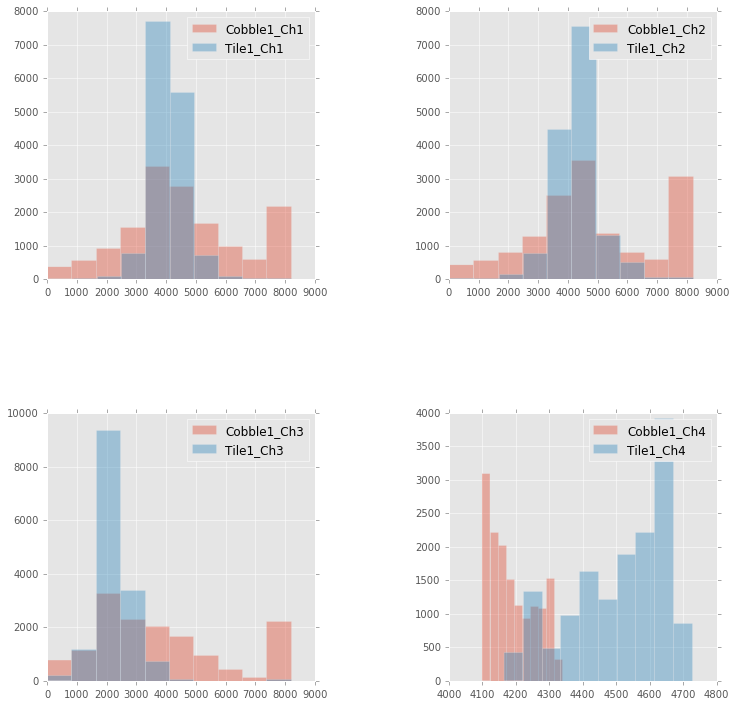

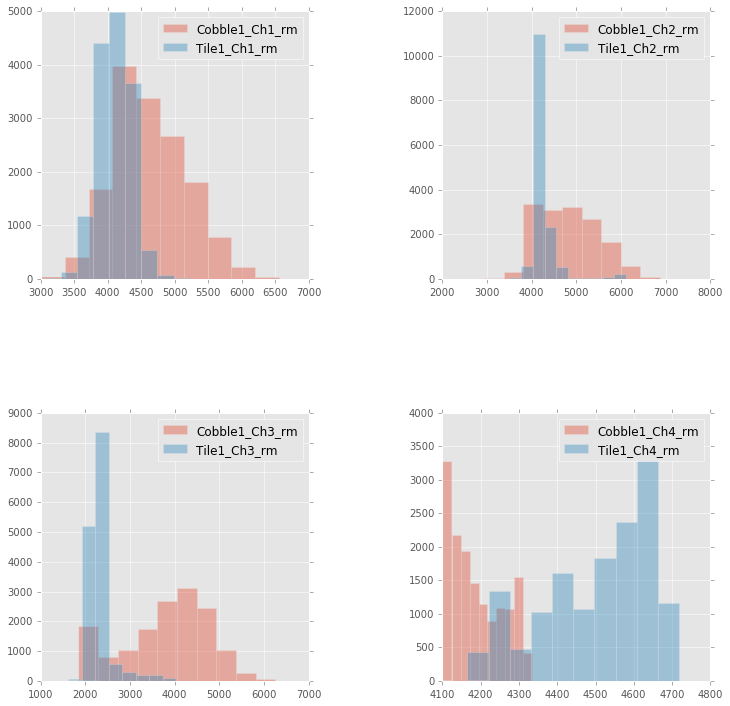

In [23]:
strClass1 = 'Cobble1'
strClass2 = 'Tile1'
plotClasses(strClass1, strClass2)

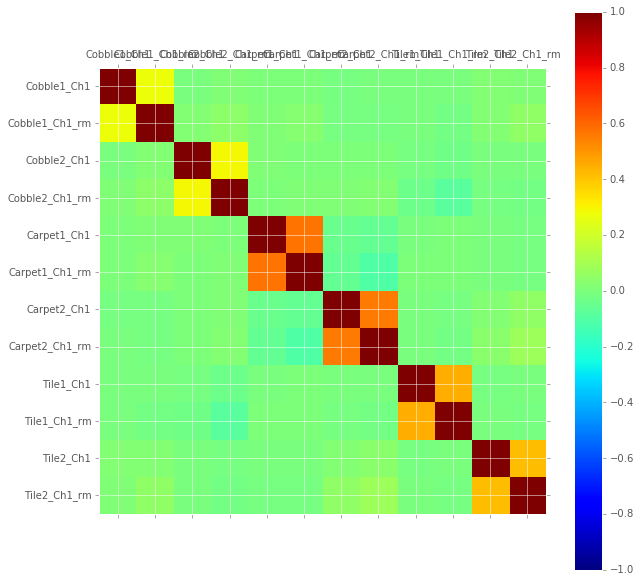

In [24]:
strChannel = 'Ch1'
plotCorrChannel(strChannel)